# Project 1 - Regression
## Forecasting the number of motor insurance claims
### This notebook uses the dateset *freMTPL2freq.csv*

(c) Nuno António 2022 - Rev. 1.0

## Dataset description

- **IDpol**: The policy ID (used to link with the claims dataset).
- **ClaimNb**: Number of claims during the exposure period.
- **Exposure**: The exposure period.
- **Area**: The area code.
- **VehPower**: The power of the car (ordered categorical).
- **VehAge**: The vehicle age, in years.
- **DrivAge**: The driver age, in years (in France, people can drive a car at 18).
- **BonusMalus**: Bonus/malus, between 50 and 350: <100 means bonus, >100 means malus in France.
- **VehBrand**: The car brand (unknown categories).
- **VehGas**: The car gas, Diesel or regular.
- **Density**: The density of inhabitants (number of inhabitants per km2) in the city the driver of the car lives in.
- **Region**: The policy regions in France (based on a standard French classification)

For additional information on the dataset check https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3164764

## Work description

### Overview
<p>You should organize into groups of 3 to 5 students, where you will assume the role of a consultant. You are asked to develop a model to forecast how many claims will each policy holder from a car insurer in France have in the following year. The insurance company wants to use this model to improve the policies' premiums (pricing).</p>
<p>Employing the CRISP-DM process model, you are expected to define, describe and explain the model built. Simultaneous, you should explain how your model can help the insurance company reaching its objectives.</p>

### Questions or additional informations
For any additional questions, don't hesitate to get in touch with the instructor. The instructor will also act as the insurance company/project stakeholder.

## Initializations and data loading

In [1]:
# Loading packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import metrics
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor 
import category_encoders as ce
from yellowbrick.model_selection import RFECV
from yellowbrick.model_selection import LearningCurve
from yellowbrick.regressor import ResidualsPlot
from yellowbrick.regressor import PredictionError

from scipy import stats

In [2]:
import warnings
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format

In [3]:
# Loading the dataset and visualizing summary statistics

ds = pd.read_csv('freMTPL2freq.csv')
ds.drop(columns='IDpol', inplace=True)
#ds = ds.sample(frac=0.2, random_state=2022)

In [4]:
ds.columns

Index(['ClaimNb', 'Exposure', 'Area', 'VehPower', 'VehAge', 'DrivAge',
       'BonusMalus', 'VehBrand', 'VehGas', 'Density', 'Region'],
      dtype='object')

In [5]:
ds.head()

,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
0,1,0.10,D,5,0,55,50,B12,Regular,1217,R82
1,1,0.77,D,5,0,55,50,B12,Regular,1217,R82
2,1,0.75,B,6,2,52,50,B12,Diesel,54,R22
3,1,0.09,B,7,0,46,50,B12,Diesel,76,R72
4,1,0.84,B,7,0,46,50,B12,Diesel,76,R72


# Data Exploration

In [6]:
# Show top rows

ds.head()

,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
0,1,0.10,D,5,0,55,50,B12,Regular,1217,R82
1,1,0.77,D,5,0,55,50,B12,Regular,1217,R82
2,1,0.75,B,6,2,52,50,B12,Diesel,54,R22
3,1,0.09,B,7,0,46,50,B12,Diesel,76,R72
4,1,0.84,B,7,0,46,50,B12,Diesel,76,R72


In [7]:
# Statistics concerning the categorical variables.

ds.describe(include=['O']).T


,count,unique,top,freq
Area,678013,6,C,191880
VehBrand,678013,11,B12,166024
VehGas,678013,2,Regular,345877
Region,678013,22,R24,160601


In [8]:
# Statistics concerning the numerical variables.

ds.describe().T

,count,mean,std,min,25%,50%,75%,max
ClaimNb,"678,013.00",0.05,0.24,0.00,0.00,0.00,0.00,16.00
Exposure,"678,013.00",0.53,0.36,0.00,0.18,0.49,0.99,2.01
VehPower,"678,013.00",6.45,2.05,4.00,5.00,6.00,7.00,15.00
VehAge,"678,013.00",7.04,5.67,0.00,2.00,6.00,11.00,100.00
DrivAge,"678,013.00",45.50,14.14,18.00,34.00,44.00,55.00,100.00
BonusMalus,"678,013.00",59.76,15.64,50.00,50.00,50.00,64.00,230.00
Density,"678,013.00","1,792.42","3,958.65",1.00,92.00,393.00,"1,658.00","27,000.00"


In [9]:
# checking the shape of the dataset.

ds.shape

(678013, 11)

In [10]:
# The data set does not contain any missing values.

ds.isna().sum()

ClaimNb       0
Exposure      0
Area          0
VehPower      0
VehAge        0
DrivAge       0
BonusMalus    0
VehBrand      0
VehGas        0
Density       0
Region        0
dtype: int64

In [11]:
# Droping the duplicate rows if any.

ds.drop_duplicates(keep=False, inplace=True)

# We can see that there are no duplicate rows.
ds.shape

(637268, 11)

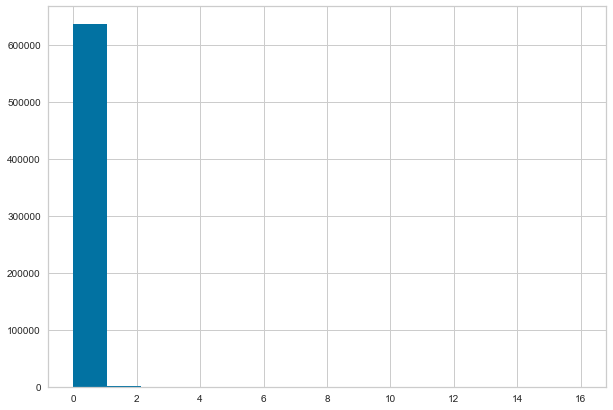

In [12]:
# The main variable is the 'ClaimNb', the histogram of the variable is as follow:

ds['ClaimNb'].hist(bins=15, figsize=(10, 7))
plt.show()

In [13]:
ds['ClaimNb'].value_counts()

0     603276
1      32110
2       1784
3         82
4          7
11         3
5          2
6          1
8          1
9          1
16         1
Name: ClaimNb, dtype: int64

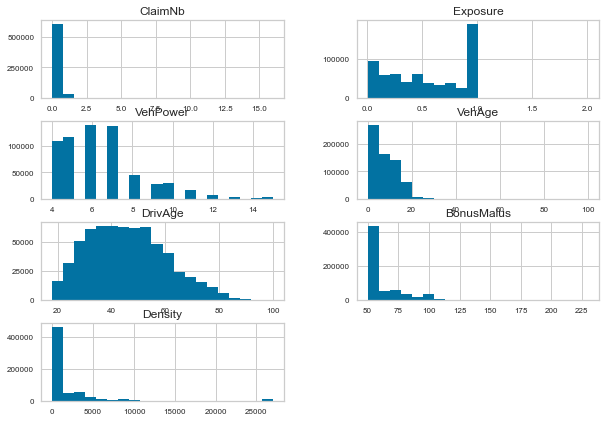

In [14]:
# Histograms of all numerical variables

numerical=ds.select_dtypes(include=[np.number]).columns.tolist()
ds[numerical].hist(bins=20, figsize=(10, 7), layout=(4, 2), xlabelsize=8, ylabelsize=8);

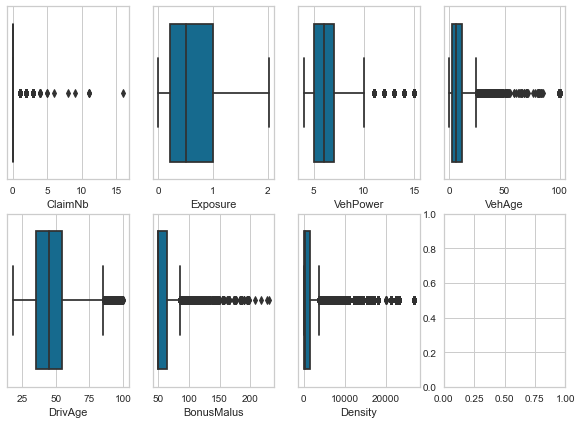

In [15]:
# Do boxplots on all numeric variables

fig, ax = plt.subplots(2, 4, figsize=(10, 7))
for var, subplot in zip(ds[numerical], ax.flatten()):
    sns.boxplot(x=ds[var], ax=subplot)
    

In [16]:
# We apply the log to the density, in order to have a normal distribution.

#ds['LogDensity'] = np.log(ds['Density'])
#ds.drop(columns='Density', inplace=True)

In [17]:
# We keep only the Exposure with less than one year, the we create the target variable.

ds = ds[(ds['Exposure']<=1) & (ds['Exposure']>= 0.1)] 

#ds['Freq'] = ds['ClaimNb']/ds['Exposure']

## Correlations between Numerical variables.

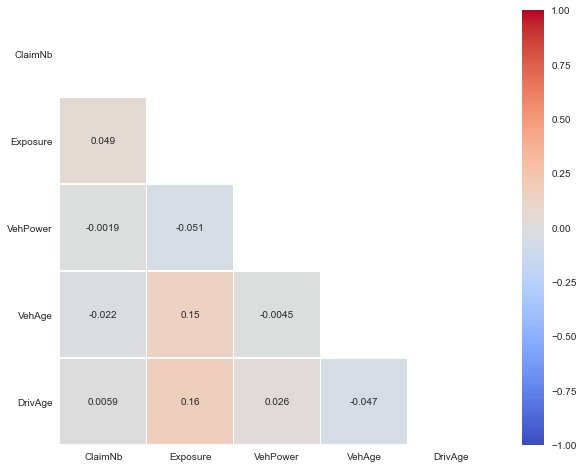

In [18]:
numerical= ['ClaimNb', 'Exposure', 'VehPower', 'VehAge', 'DrivAge']

corr = ds[numerical].corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)]= True

f, ax = plt.subplots(figsize=(10, 8))
heatmap = sns.heatmap(corr,
                      mask = mask,
                      square = True,
                      linewidths = .5,
                      cmap = 'coolwarm',
                      vmin = -1,
                      vmax = 1,
                      annot = True,
                      annot_kws = {'size': 10})

#add the column names as labels
ax.set_yticklabels(corr.columns, rotation = 0)
ax.set_xticklabels(corr.columns, rotation = 0)
sns.set_style({'xtick.bottom': True}, {'ytick.left': True})

#correct first and last line plot (bug on previous versions of Seaborn)
#bottom, top = ax.get_ylim()
#ax.set_ylim(bottom + 0.5, top - 0.5)

In [19]:
# As we can see from the figure above the variables are not very correlated to each others,
#  expect for "DrivAge" and "BonusMalus"

## Categorical variables exploration.

In [20]:
# Transform a list of columns to categorical

cols = ['Area', 'VehBrand', 'VehGas', 'Region']
ds[cols] = ds[cols].apply(lambda x:x.astype('category'))

In [21]:
# Ckeck the top counts of all categorical variables

categorical=ds.select_dtypes(exclude=["number","bool_","object_"]).columns.tolist()
categorical
for var in ds[categorical]:
    print(var,":\n",ds[var].value_counts(), sep="")

Area:
C    157092
D    121088
E    104191
A     89153
B     63519
F     14188
Name: Area, dtype: int64
VehBrand:
B1     134160
B2     132648
B12    129404
B3      43195
B5      28607
B6      22888
B4      20105
B10     14294
B11     10617
B13      9986
B14      3327
Name: VehBrand, dtype: int64
VehGas:
Regular    284024
Diesel     265207
Name: VehGas, dtype: int64
Region:
R24    141297
R82     69516
R93     60190
R11     54069
R53     37778
R52     31981
R91     25172
R72     23264
R31     19339
R54     16401
R73     12591
R41     11362
R25      9579
R26      8320
R22      6364
R23      5085
R83      4186
R74      3854
R94      3650
R21      2375
R42      1865
R43       993
Name: Region, dtype: int64


In [22]:
# Exploration of categorical variables: cross table of ClaimNb and Area.

tb1 = pd.crosstab(index=ds['ClaimNb'], columns=ds['Area'])
tb1

Area,A,B,C,D,E,F
ClaimNb,,,,,,
0,84674,60178,148560,113918,97633,13274
1,4277,3189,8060,6757,6118,850
2,194,149,454,388,412,59
3,5,3,18,21,24,5
4,2,0,0,1,3,0
5,0,0,0,0,1,0
6,0,0,0,1,0,0
8,0,0,0,1,0,0
11,1,0,0,0,0,0


In [23]:
# Exploration of categorical variables: cross table of ClaimNb and VehBrand.

tb2 = pd.crosstab(index=ds['ClaimNb'], columns=ds['VehBrand'])
tb2

VehBrand,B1,B10,B11,B12,B13,B14,B2,B3,B4,B5,B6
ClaimNb,,,,,,,,,,,
0,126398,13526,9968,122800,9401,3175,124925,40712,18934,26813,21585
1,7356,729,613,6118,551,147,7340,2350,1120,1693,1234
2,386,38,33,465,33,4,358,127,46,99,67
3,17,1,3,18,1,1,22,5,4,2,2
4,0,0,0,3,0,0,1,1,1,0,0
5,0,0,0,0,0,0,1,0,0,0,0
6,1,0,0,0,0,0,0,0,0,0,0
8,1,0,0,0,0,0,0,0,0,0,0
11,0,0,0,0,0,0,1,0,0,0,0


In [24]:
# Exploration of categorical variables: cross table of ClaimNb and VehGas.

tb3 = pd.crosstab(index=ds['ClaimNb'], columns=ds['VehGas'])
tb3

VehGas,Diesel,Regular
ClaimNb,,
0,250622,267615
1,13738,15513
2,809,847
3,33,43
4,3,3
5,1,0
6,0,1
8,0,1
11,1,0


In [25]:
# Exploration of categorical variables: cross table of ClaimNb and Region.

#tb4 = pd.crosstab(index=ds['ClaimNb'], columns=ds['Region'])
tb4 = pd.crosstab(index=ds['Region'], columns=ds['ClaimNb'])
tb4

ClaimNb,0,1,2,3,4,5,6,8,11,16
Region,,,,,,,,,,
R11,50896,2942,220,10,1,0,0,0,0,0
R21,2259,109,7,0,0,0,0,0,0,0
R22,6003,345,16,0,0,0,0,0,0,0
R23,4853,215,17,0,0,0,0,0,0,0
R24,132878,8060,347,9,2,0,0,0,1,0
R25,9013,540,26,0,0,0,0,0,0,0
R26,7889,412,19,0,0,0,0,0,0,0
R31,18371,900,63,4,1,0,0,0,0,0
R41,10829,514,18,1,0,0,0,0,0,0


<AxesSubplot:xlabel='ClaimNb'>

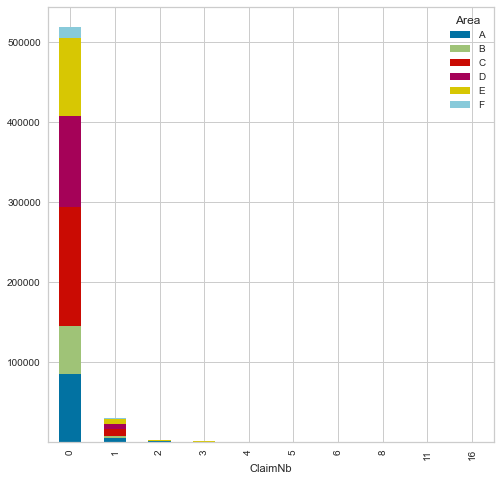

In [26]:
# Visual exploration of the cross table

tb1.plot(kind="bar", figsize=(8,8), stacked=True)

<AxesSubplot:xlabel='ClaimNb'>

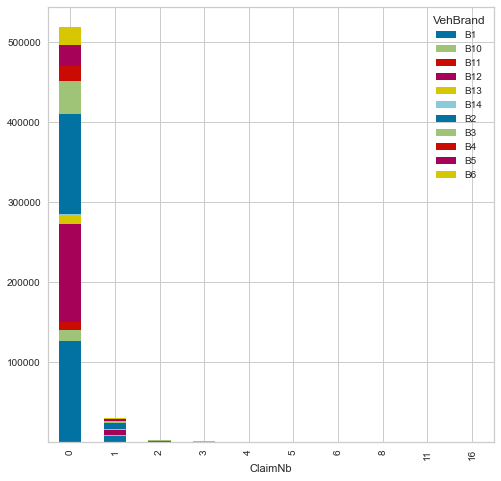

In [27]:
# Visual exploration of the cross table

tb2.plot(kind="bar", figsize=(8,8), stacked=True)

<AxesSubplot:xlabel='ClaimNb'>

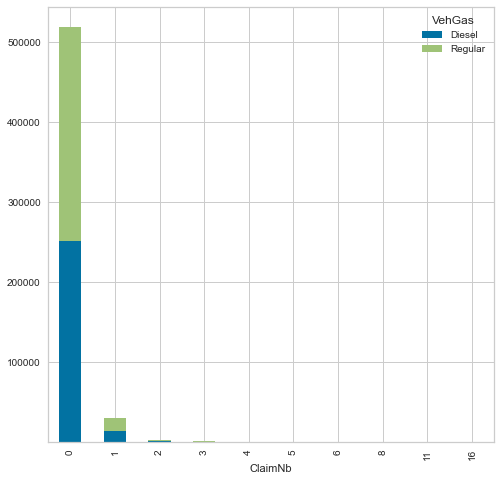

In [28]:
# Visual exploration of the cross table

tb3.plot(kind="bar", figsize=(8,8), stacked=True)

<AxesSubplot:xlabel='Region'>

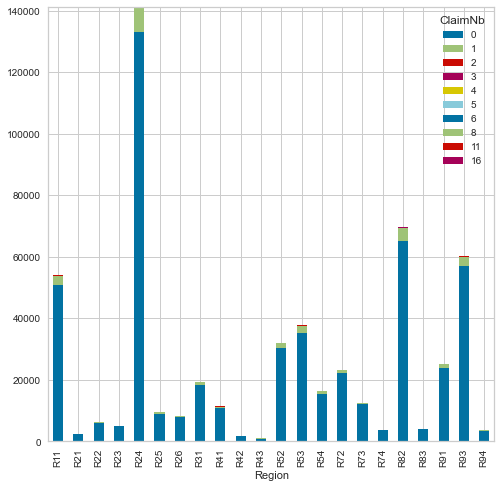

In [29]:
# Visual exploration of the cross table tb4, 
# we can not really see any paterns.

tb4.plot(kind="bar", figsize=(8,8), stacked=True)

In [30]:
# Pair plot some of the numerical variables with VehGas.
## ['Area', 'VehBrand', 'VehGas', 'Region'].
# This cell takes too much time to run and should be avoided

#cols = ['ClaimNb', 'Exposure', 'VehPower', 'VehAge', 'DrivAge', 'BonusMalus', 'Density', 'VehGas']
#g = sns.pairplot(ds[cols], hue="VehGas")

### Bar plots

In [31]:
ds.head()

,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
0,1,0.10,D,5,0,55,50,B12,Regular,1217,R82
1,1,0.77,D,5,0,55,50,B12,Regular,1217,R82
2,1,0.75,B,6,2,52,50,B12,Diesel,54,R22
4,1,0.84,B,7,0,46,50,B12,Diesel,76,R72
5,1,0.52,E,6,2,38,50,B12,Regular,3003,R31


In [32]:
# Why does it take too much time to run certain plots.

#ax = ds.plot.bar(x='Area', y='ClaimNb', rot=0)

In [33]:
#ax = ds.plot.bar(x='VehBrand', y='ClaimNb', rot=0)

In [34]:
#ax = ds.plot.bar(x='VehGas', y='ClaimNb', rot=0)

In [35]:
#ax = ds.plot.bar(x='Region', y='ClaimNb', rot=0)

# Data Preparation

In [36]:
# Create a modeling dataset from the original dataset
X = ds.copy(deep=True)

In [37]:
X.describe().T

,count,mean,std,min,25%,50%,75%,max
ClaimNb,"549,231.00",0.06,0.25,0.00,0.00,0.00,0.00,16.00
Exposure,"549,231.00",0.63,0.32,0.10,0.33,0.63,1.00,1.00
VehPower,"549,231.00",6.44,2.04,4.00,5.00,6.00,7.00,15.00
VehAge,"549,231.00",7.24,5.64,0.00,2.00,6.00,11.00,100.00
DrivAge,"549,231.00",46.06,14.30,18.00,35.00,45.00,55.00,100.00
BonusMalus,"549,231.00",59.24,15.41,50.00,50.00,50.00,64.00,230.00
Density,"549,231.00","1,722.52","3,928.88",1.00,86.00,355.00,"1,487.00","27,000.00"


In [38]:
# Bin the BonusMalus.
# I need to pay attention to the signs strictly superior or strictly inferior.
binsInterval = [0, 100, 500] # Create bins interval based on distribution/quartiles.
intervalLabels = ['(0, 100]', '(100, 500]']
X['BonusMalus_binned'] = pd.cut(X['BonusMalus'], bins = binsInterval, labels=intervalLabels)
X['BonusMalus_binned'].replace(['(0, 100]', '(100, 500]'], ['Bonus', 'Malus'], inplace=True)

# We then need to drop the column 'BonusMalus'.
X.drop(columns=['BonusMalus'], inplace=True)

## One Hot Encoding

In [39]:
# Encode categorical values into dummy variables.

categorical = ['Area', 'VehBrand', 'VehGas', 'Region', 'BonusMalus_binned'] # 'Region'
#X.drop(columns=['Area', 'VehBrand', 'VehGas', 'Region', 'BonusMalus_binned'], inplace=True)

ce_one_hot = ce.OneHotEncoder(cols = categorical, use_cat_names=True)
#.HelmertEncoder(cols = categorical)
#OneHotEncoder(cols = categorical, use_cat_names=True)
X = ce_one_hot.fit_transform(X)

In [ ]:
# Before we have 12 variables, now we have XX.

X.shape

(549231, 49)

In [ ]:
# The new data set format.

X.head()

,ClaimNb,Exposure,Area_D,Area_B,Area_E,Area_C,Area_F,Area_A,VehPower,VehAge,...,Region_R73,Region_R42,Region_R25,Region_R21,Region_R41,Region_R43,Region_R23,Region_R74,BonusMalus_binned_Bonus,BonusMalus_binned_Malus
0,1,0.10,1,0,0,0,0,0,5,0,...,0,0,0,0,0,0,0,0,1,0
1,1,0.77,1,0,0,0,0,0,5,0,...,0,0,0,0,0,0,0,0,1,0
2,1,0.75,0,1,0,0,0,0,6,2,...,0,0,0,0,0,0,0,0,1,0
4,1,0.84,0,1,0,0,0,0,7,0,...,0,0,0,0,0,0,0,0,1,0
5,1,0.52,0,0,1,0,0,0,6,2,...,0,0,0,0,0,0,0,0,1,0


## Removing outliers

In [ ]:
X.describe().T

,count,mean,std,min,25%,50%,75%,max
ClaimNb,"549,231.00",0.06,0.25,0.00,0.00,0.00,0.00,16.00
Exposure,"549,231.00",0.63,0.32,0.10,0.33,0.63,1.00,1.00
Area_D,"549,231.00",0.22,0.41,0.00,0.00,0.00,0.00,1.00
Area_B,"549,231.00",0.12,0.32,0.00,0.00,0.00,0.00,1.00
Area_E,"549,231.00",0.19,0.39,0.00,0.00,0.00,0.00,1.00
Area_C,"549,231.00",0.29,0.45,0.00,0.00,0.00,1.00,1.00
Area_F,"549,231.00",0.03,0.16,0.00,0.00,0.00,0.00,1.00
Area_A,"549,231.00",0.16,0.37,0.00,0.00,0.00,0.00,1.00
VehPower,"549,231.00",6.44,2.04,4.00,5.00,6.00,7.00,15.00
VehAge,"549,231.00",7.24,5.64,0.00,2.00,6.00,11.00,100.00


In [ ]:
# From the analysis of the box plots we can easily see an obvious outlier which is 16 number of claims,
#  this value should be droped. 
#X = X[((X['ClaimNb'] != 16))]

In [ ]:
#X['ClaimNb'].unique()

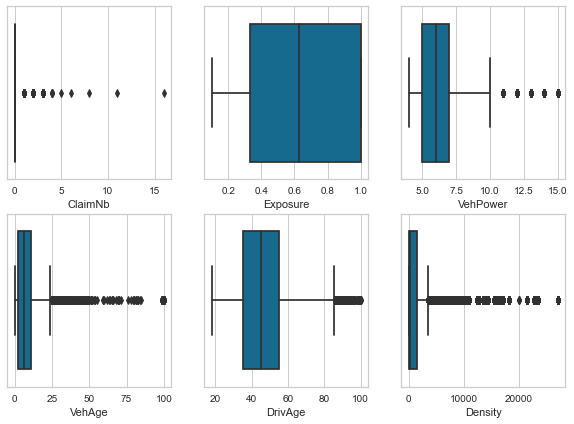

In [ ]:
numerical = ['ClaimNb', 'Exposure', 'VehPower', 'VehAge', 'DrivAge', 'Density']

# Plotting boxplots for all numerical variables.

fig, ax = plt.subplots(2, 3, figsize=(10, 7))
for var, subplot in zip(ds[numerical], ax.flatten()):
    sns.boxplot(x=X[var], ax=subplot)

In [ ]:
# Function to find outliers on columns based on percentile.

def removeOutliers(df, colList, lowPercentile=0.05, highPercentile=0.95, verbose=False):
    quant_df = df[colList].quantile([lowPercentile, highPercentile])
    if verbose:
        print(quant_df)
    for name in list(df[colList].columns):
        df = df[(df[name] >= quant_df.loc[lowPercentile, name]) & (df[name] <= quant_df.loc[highPercentile, name])]
    return df

In [ ]:
#X['LogFreq'] = np.log1p(X['Freq'])
#.quantile([0.85, 0.90, 0.945])

In [ ]:
#X['LogFreq'].quantile([0.80, 0.85, 0.9, 0.95, 0.999, 1.0])

In [ ]:
X.describe().T

,count,mean,std,min,25%,50%,75%,max
ClaimNb,"549,231.00",0.06,0.25,0.00,0.00,0.00,0.00,16.00
Exposure,"549,231.00",0.63,0.32,0.10,0.33,0.63,1.00,1.00
Area_D,"549,231.00",0.22,0.41,0.00,0.00,0.00,0.00,1.00
Area_B,"549,231.00",0.12,0.32,0.00,0.00,0.00,0.00,1.00
Area_E,"549,231.00",0.19,0.39,0.00,0.00,0.00,0.00,1.00
Area_C,"549,231.00",0.29,0.45,0.00,0.00,0.00,1.00,1.00
Area_F,"549,231.00",0.03,0.16,0.00,0.00,0.00,0.00,1.00
Area_A,"549,231.00",0.16,0.37,0.00,0.00,0.00,0.00,1.00
VehPower,"549,231.00",6.44,2.04,4.00,5.00,6.00,7.00,15.00
VehAge,"549,231.00",7.24,5.64,0.00,2.00,6.00,11.00,100.00


In [ ]:
np.log1p(X['ClaimNb']).quantile([0.95, 0.96, 0.97, 0.98, 0.99, 0.999])

0.95   0.69
0.96   0.69
0.97   0.69
0.98   0.69
0.99   0.69
1.00   1.10
Name: ClaimNb, dtype: float64

In [ ]:
# Checking the skew of the target variable.

X['ClaimNb'].skew()

5.027193446722617

In [ ]:
# Checking the skew of log transform of the target variable.

np.log1p(X['ClaimNb']).skew()

4.028224474014185

In [ ]:
# Checking the skew of the square root transform of the target variable. 

np.sqrt(X['ClaimNb']).skew()

3.938187636199319

In [ ]:
# Checking the skew of a log transform of the target variable.

np.log(2 + X['ClaimNb']).skew()

4.137273728045051

In [ ]:
# Performing A Box Cox transformation to the 'ClaimNb' variable.

ClaimNb_boxcox = stats.boxcox(np.log(2 + X['ClaimNb']))[0] # 
X['ClaimNb_boxcox'] = ClaimNb_boxcox
X['ClaimNb_boxcox'].skew()

3.844534583647115

In [ ]:
# Checking the distribution of the new variable.

X['ClaimNb_boxcox'].describe()

count   549,231.00
mean    -22,449.28
std       5,490.07
min     -23,791.89
25%     -23,791.89
50%     -23,791.89
75%     -23,791.89
max           0.03
Name: ClaimNb_boxcox, dtype: float64

In [ ]:
# Finding and removing the outliers.

X = removeOutliers(X, colList=['VehPower', 'VehAge', 'DrivAge', 'Density'] , lowPercentile=0.02, highPercentile=0.95, verbose=True)
X = removeOutliers(X, colList=['ClaimNb_boxcox'] , lowPercentile=0.05, highPercentile=0.95, verbose=True)


      VehPower  VehAge  DrivAge  Density
0.02      4.00    0.00    22.00    12.00
0.95     11.00   17.00    72.00 7,049.00
      ClaimNb_boxcox
0.05      -23,791.89
0.95            0.03


## Normalizing the columns.

In [ ]:
# Creating the target variable.

y = X['ClaimNb_boxcox']/X['Exposure']

X = X.drop(columns=['ClaimNb', 'ClaimNb_boxcox']) # 'Exposure'

In [ ]:
X.head()

,Exposure,Area_D,Area_B,Area_E,Area_C,Area_F,Area_A,VehPower,VehAge,DrivAge,...,Region_R73,Region_R42,Region_R25,Region_R21,Region_R41,Region_R43,Region_R23,Region_R74,BonusMalus_binned_Bonus,BonusMalus_binned_Malus
0,0.10,1,0,0,0,0,0,5,0,55,...,0,0,0,0,0,0,0,0,1,0
1,0.77,1,0,0,0,0,0,5,0,55,...,0,0,0,0,0,0,0,0,1,0
2,0.75,0,1,0,0,0,0,6,2,52,...,0,0,0,0,0,0,0,0,1,0
4,0.84,0,1,0,0,0,0,7,0,46,...,0,0,0,0,0,0,0,0,1,0
5,0.52,0,0,1,0,0,0,6,2,38,...,0,0,0,0,0,0,0,0,1,0


In [ ]:
# Normalizing all the columns.
# scaler returns an array, so the dataframe must be recreated.

X = pd.DataFrame(preprocessing.StandardScaler().fit_transform(X.values), columns=X.columns,index=X.index)


# Modeling.

## Multivariate regression.

In [ ]:
# Split the dataset intro train and test sets.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle =True, random_state=2022)

In [ ]:
# Initializing the model.

lr_regr = linear_model.Ridge(alpha=1.0) # LinearRegression()

In [ ]:
# Apply RFECV (Recursive Feature Elimination) to select features
# see https://www.scikit-yb.org/en/latest/api/model_selection/rfecv.html

#vis = RFECV(lr_regr, cv=5, scoring='r2')
#vis.fit(X_train, y_train)
#vis.show()

In [ ]:
#X.columns[vis.support_]

In [ ]:
# Features to include, we have to change the data frame and only keep the columns that are returned by RFECV. 

# In this case it only consider one variable.
#X = X[X.columns[vis.support_]]

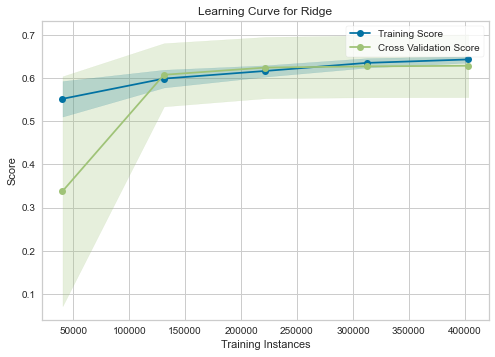

<AxesSubplot:title={'center':'Learning Curve for Ridge'}, xlabel='Training Instances', ylabel='Score'>

In [ ]:
# Plot the learning curve

cv = 10
sizes = np.linspace(0.1, 1.0, 5)
visualizer = LearningCurve(estimator=lr_regr, cv=cv, scoring='r2', train_sizes=sizes, n_jobs=4, random_state=2022)
visualizer.fit(X, y)
visualizer.show()     

In [ ]:
# Create and train the model.

lr_regr.fit(X_train, y_train)
# , regressor__sample_weight=X_train["Exposure"]

Ridge()

In [ ]:
# Print the Intercept
#print('Intercept:',lr_regr.intercept_, '\n')

# Print Coefficients by descending "importance"
#formattedList = [format(float(i),'.6f') for i in lr_regr.coef_]
#formattedList2 = [format(abs(float(i)),'.6f') for i in lr_regr.coef_]
#data_tuples = list(zip(X.columns,formattedList,formattedList2))
#coeff_df = pd.DataFrame(data=data_tuples, columns=['Feature','Coefficient','AbsCoefficient'])
#coeff_df['AbsCoefficient']=coeff_df['AbsCoefficient'].astype(float)
#coeff_df.sort_values('AbsCoefficient', axis=0, inplace=True, ascending=False)
#coeff_df

### Evaluation

In [ ]:
# predict y for X_train and X_test.

y_pred_train = lr_regr.predict(X_train) 
y_pred_test = lr_regr.predict(X_test) 

In [ ]:
# Function to create dataframe with metrics
def performanceMetricsDF(metricsObj, yTrain, yPredTrain, yTest, yPredTest):
  measures_list = ['MAE','RMSE', 'R^2','MAPE (%)','MAX Error']
  train_results = [metricsObj.mean_absolute_error(yTrain, yPredTrain),
                np.sqrt(metricsObj.mean_squared_error(yTrain, yPredTrain)),
                metricsObj.r2_score(yTrain, yPredTrain),
                metricsObj.mean_absolute_percentage_error(yTrain, yPredTrain),
                metricsObj.max_error(yTrain, yPredTrain)]
  test_results = [metricsObj.mean_absolute_error(yTest, yPredTest),
                np.sqrt(metricsObj.mean_squared_error(yTest, yPredTest)),
                metricsObj.r2_score(yTest, yPredTest),
                  metricsObj.mean_absolute_percentage_error(yTest, yPredTest),
                metricsObj.max_error(yTest, yPredTest)]
  resultsDF = pd.DataFrame({'Measure': measures_list, 'Train': train_results, 'Test':test_results})
  return(resultsDF)

In [ ]:
# Show the results performance.

resultsDF = performanceMetricsDF(metrics, y_train, y_pred_train, y_test, y_pred_test)
resultsDF

,Measure,Train,Test
0,MAE,"20,457.32","20,457.78"
1,RMSE,"29,097.62","29,081.50"
2,R^2,0.64,0.64
3,MAPE (%),"43,849.25","43,838.94"
4,MAX Error,"129,629.33","126,351.38"


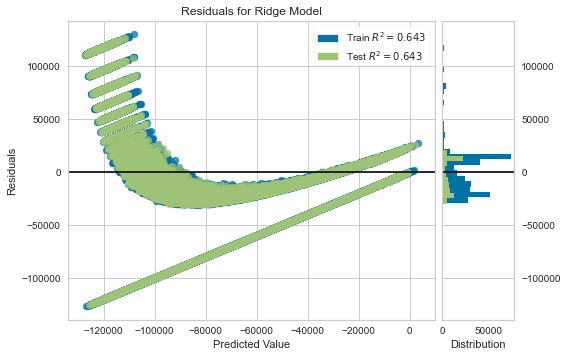

<AxesSubplot:title={'center':'Residuals for Ridge Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [ ]:
# Visualize the residuals.

residuals_vis = ResidualsPlot(lr_regr, qqplot=False, hist=True)
residuals_vis.fit(X_train, y_train)  # Fit the training data to the visualizer
residuals_vis.score(X_test, y_test)  # Evaluate the model on the test data
residuals_vis.show() 

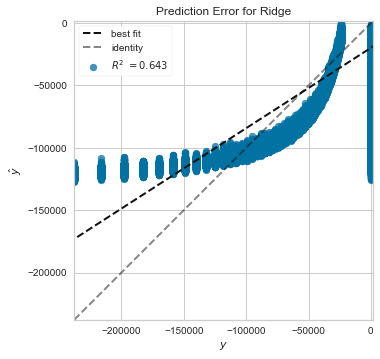

In [ ]:
# Visualize the prediction error
predError_vis = PredictionError(lr_regr)

predError_vis.fit(X_train, y_train)  # Fit the training data to the visualizer
predError_vis.score(X_test, y_test)  # Evaluate the model on the test data
predError_vis.show() 
plt.show()

In [ ]:
X_train.head()

,Exposure,Area_D,Area_B,Area_E,Area_C,Area_F,Area_A,VehPower,VehAge,DrivAge,...,Region_R73,Region_R42,Region_R25,Region_R21,Region_R41,Region_R43,Region_R23,Region_R74,BonusMalus_binned_Bonus,BonusMalus_binned_Malus
427656,-1.22,-0.56,-0.37,-0.47,-0.67,0.00,2.37,-0.16,-1.18,1.23,...,-0.16,-0.06,-0.14,-0.07,-0.15,-0.04,-0.10,-0.08,0.10,-0.10
159495,1.17,-0.56,2.67,-0.47,-0.67,0.00,-0.42,0.41,1.28,0.83,...,-0.16,-0.06,-0.14,-0.07,-0.15,-0.04,-0.10,-0.08,0.10,-0.10
264768,-0.72,1.78,-0.37,-0.47,-0.67,0.00,-0.42,-0.16,-1.18,-0.22,...,-0.16,-0.06,-0.14,-0.07,-0.15,-0.04,-0.10,-0.08,0.10,-0.10
347555,-0.68,-0.56,-0.37,2.13,-0.67,0.00,-0.42,-1.30,-1.39,0.91,...,-0.16,-0.06,-0.14,-0.07,-0.15,-0.04,-0.10,-0.08,0.10,-0.10
557806,1.17,-0.56,2.67,-0.47,-0.67,0.00,-0.42,2.68,0.46,-0.30,...,-0.16,-0.06,-0.14,-0.07,-0.15,-0.04,-0.10,-0.08,0.10,-0.10


### Decision Tree

In [ ]:
# Initialize model

tree_regr = tree.DecisionTreeRegressor(random_state=2022, max_depth=5) # max_depth=10

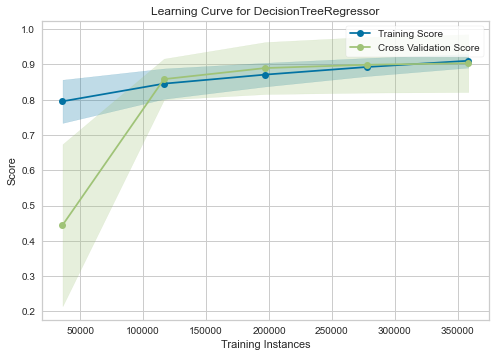

<AxesSubplot:title={'center':'Learning Curve for DecisionTreeRegressor'}, xlabel='Training Instances', ylabel='Score'>

In [ ]:
# Plot the learning curve
cv = 5 #10
sizes = np.linspace(0.1, 1.0, 5)
visualizer = LearningCurve(estimator=tree_regr, cv=cv, scoring='r2', train_sizes=sizes, n_jobs=4, random_state=2022)
visualizer.fit(X, y)
visualizer.show()     

In [ ]:
# Create and train the model
tree_regr.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=5, random_state=2022)

In [ ]:

# Explore feature importance (Gini importance - normalized)
#formattedList = [float(format(member,'.6f')) for member in tree_regr.feature_importances_]
#formattedList2 = [abs(float(format(member,'.6f'))) for member in tree_regr.feature_importances_]
#data_tuples = list(zip(X.columns,formattedList,formattedList2))
#coeff_df = pd.DataFrame(data=data_tuples, columns=['Feature','Coefficient','AbsCoefficient'])
#coeff_df.reset_index(drop=True, inplace=True)
#coeff_df.sort_values(by=['AbsCoefficient'], inplace=True, ascending=False)
#coeff_df

In [ ]:
# I DON'T NEED THIS. 
# Plot the tree
# Install Graphviz using "pip install graphviz" or "conda install python-graphviz"

#import graphviz
#dot_data = tree.export_graphviz(tree_regr, out_file=None, 
#                      feature_names=list(X_train.columns),  
#                      class_names='Returns',  
#                      filled=True, rounded=True,  
#                      special_characters=True)  
#graph = graphviz.Source(dot_data)  
#graph 

#### Evaluation

In [ ]:
# predict y for X_train and X_test
y_pred_train = tree_regr.predict(X_train) 
y_pred_test = tree_regr.predict(X_test) 

In [ ]:
X_train.head()

,Exposure,Area_D,Area_B,Area_E,Area_C,Area_F,Area_A,VehPower,VehAge,DrivAge,...,Region_R73,Region_R42,Region_R25,Region_R21,Region_R41,Region_R43,Region_R23,Region_R74,BonusMalus_binned_Bonus,BonusMalus_binned_Malus
427656,-1.22,-0.56,-0.37,-0.47,-0.67,0.00,2.37,-0.16,-1.18,1.23,...,-0.16,-0.06,-0.14,-0.07,-0.15,-0.04,-0.10,-0.08,0.10,-0.10
159495,1.17,-0.56,2.67,-0.47,-0.67,0.00,-0.42,0.41,1.28,0.83,...,-0.16,-0.06,-0.14,-0.07,-0.15,-0.04,-0.10,-0.08,0.10,-0.10
264768,-0.72,1.78,-0.37,-0.47,-0.67,0.00,-0.42,-0.16,-1.18,-0.22,...,-0.16,-0.06,-0.14,-0.07,-0.15,-0.04,-0.10,-0.08,0.10,-0.10
347555,-0.68,-0.56,-0.37,2.13,-0.67,0.00,-0.42,-1.30,-1.39,0.91,...,-0.16,-0.06,-0.14,-0.07,-0.15,-0.04,-0.10,-0.08,0.10,-0.10
557806,1.17,-0.56,2.67,-0.47,-0.67,0.00,-0.42,2.68,0.46,-0.30,...,-0.16,-0.06,-0.14,-0.07,-0.15,-0.04,-0.10,-0.08,0.10,-0.10


In [ ]:
# Show performance results
resultsDF = performanceMetricsDF(metrics, y_train, y_pred_train, y_test, y_pred_test)
resultsDF

,Measure,Train,Test
0,MAE,"4,929.14","4,968.15"
1,RMSE,"14,591.12","14,693.82"
2,R^2,0.91,0.91
3,MAPE (%),"45,459.95","45,878.11"
4,MAX Error,"229,988.55","229,988.55"


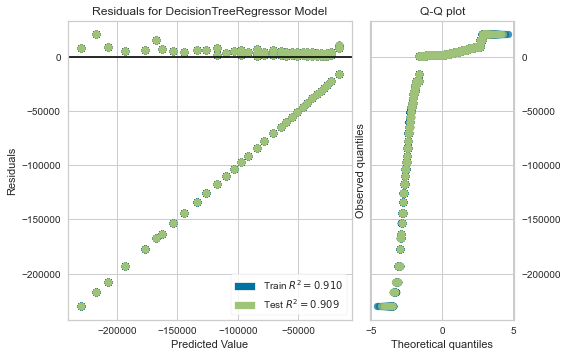

<AxesSubplot:title={'center':'Residuals for DecisionTreeRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [ ]:
# Visualize the residuals
residuals_vis = ResidualsPlot(tree_regr, qqplot=True, hist=False)
residuals_vis.fit(X_train, y_train)  # Fit the training data to the visualizer
residuals_vis.score(X_test, y_test)  # Evaluate the model on the test data
residuals_vis.show() 

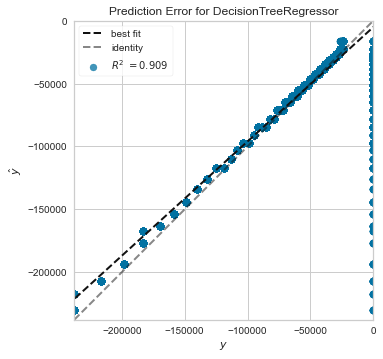

<AxesSubplot:title={'center':'Prediction Error for DecisionTreeRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [ ]:
# Visualize the prediction error.

predError_vis = PredictionError(tree_regr)
predError_vis.fit(X_train, y_train)  # Fit the training data to the visualizer
predError_vis.score(X_test, y_test)  # Evaluate the model on the test data
predError_vis.show() 


### Random Forest

In [ ]:
rf_regr = RandomForestRegressor(n_estimators=10)  # max_depth=5
rf_regr.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10)

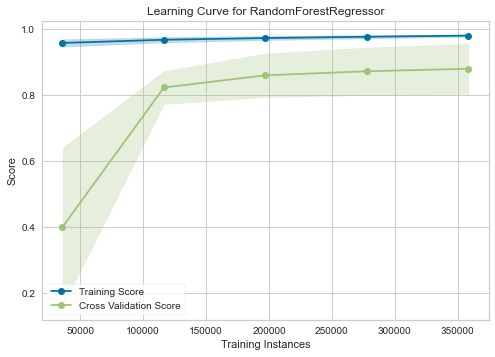

<AxesSubplot:title={'center':'Learning Curve for RandomForestRegressor'}, xlabel='Training Instances', ylabel='Score'>

In [ ]:
# Plot the learning curve

cv = 5 #10
sizes = np.linspace(0.1, 1.0, 5)
visualizer = LearningCurve(estimator=rf_regr, cv=cv, scoring='r2', train_sizes=sizes, n_jobs=-1, random_state=2022)
visualizer.fit(X, y)
visualizer.show()     

In [ ]:
# predict y for X_train and X_test

y_pred_train = rf_regr.predict(X_train) 
y_pred_test = rf_regr.predict(X_test) 

In [ ]:
# Show performance results

resultsDF = performanceMetricsDF(metrics, y_train, y_pred_train, y_test, y_pred_test)
resultsDF

,Measure,Train,Test
0,MAE,"1,982.46","5,368.05"
1,RMSE,"6,807.28","16,061.37"
2,R^2,0.98,0.89
3,MAPE (%),"16,381.47","44,399.12"
4,MAX Error,"214,127.27","237,919.19"


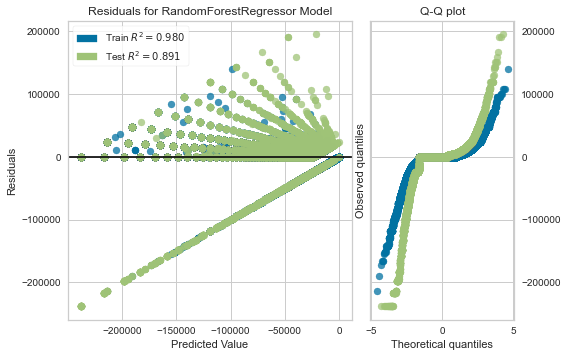

<AxesSubplot:title={'center':'Residuals for RandomForestRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [ ]:
# Visualize the residuals

residuals_vis = ResidualsPlot(rf_regr, qqplot=True, hist=False)
residuals_vis.fit(X_train, y_train)  # Fit the training data to the visualizer
residuals_vis.score(X_test, y_test)  # Evaluate the model on the test data
residuals_vis.show() 

## Classification Problem

In [ ]:
X = ds.copy()

In [ ]:
X.columns

Index(['ClaimNb', 'Exposure', 'Area', 'VehPower', 'VehAge', 'DrivAge',
       'BonusMalus', 'VehBrand', 'VehGas', 'Density', 'Region'],
      dtype='object')

In [ ]:
y = X['ClaimNb']
X.drop(columns='ClaimNb', inplace=True)

In [ ]:
# Bin the BonusMalus.
# I need to pay attention to the signs strictly superior or strictly inferior.
binsInterval = [0, 100, 500] # Create bins interval based on distribution/quartiles.
intervalLabels = ['(0, 100]', '(100, 500]']
X['BonusMalus_binned'] = pd.cut(X['BonusMalus'], bins = binsInterval, labels=intervalLabels)
X['BonusMalus_binned'].replace(['(0, 100]', '(100, 500]'], ['Bonus', 'Malus'], inplace=True)

# We then need to drop the column 'BonusMalus'.
X.drop(columns=['BonusMalus'], inplace=True)

In [ ]:
# Encode categorical values into dummy variables.

categorical = ['Area', 'VehBrand', 'VehGas', 'BonusMalus_binned', 'Region'] 

ce_one_hot = ce.HelmertEncoder(cols = categorical)
#OneHotEncoder(cols = categorical, use_cat_names=True)
X = ce_one_hot.fit_transform(X)

In [ ]:
X = pd.DataFrame(preprocessing.StandardScaler().fit_transform(X.values), columns=X.columns,index=X.index)

In [ ]:
# Split the dataset intro train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, test_size = 0.3,
                                                     shuffle =True, random_state=2022)

In [ ]:
clf_lr = linear_model.LogisticRegression(random_state=2022)
clf_lr.fit(X_train, y_train)


LogisticRegression(random_state=2022)

In [ ]:
y_pred_train = clf_lr.predict(X_train) 
y_pred_test = clf_lr.predict(X_test) 

In [ ]:
metrics.f1_score(y_train, y_pred_train, average='micro')

0.9435937585346759

In [ ]:
metrics.f1_score(y_test, y_pred_test, average='micro')

0.9435091339442859